In [24]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from icedef import statoil_arcticnet_data as sd
from icedef import test_case, plot, simulator

In [5]:
reload(sd)

<module 'icedef.statoil_arcticnet_data' from '/home/evankielley/IceDEF/icedef/statoil_arcticnet_data.py'>

In [41]:
plt.rcParams['figure.figsize'] = (12, 12)

In [14]:
def calc_mean_error(lats_lons, ref_lats_lons):
    
    # lats_lons and ref_lats_lons must be a list of xarray DataArrays with time as a dimension
    
    lats, lons = lats_lons
    ref_lats, ref_lons = ref_lats_lons
    
    n = len(ref_lats.values)
    
    errs = np.zeros(n)
    
    for i in range(n):
        ref_lat = ref_lats.values[i]
        ref_lon = ref_lons.values[i]
        time = ref_lats.time.values[i]
        lat = float(lats.interp(time=time, assume_sorted=True).values)
        lon = float(lons.interp(time=time, assume_sorted=True).values)
        errs[i] = np.sqrt((ref_lon - lon)**2 + (ref_lat - lat)**2)
    
    return np.mean(errs)

# Test Case B (Beacons 204980 and 906790)

In [11]:
beacon_id = '20498'
df = sd.get_beacon_df(beacon_id=beacon_id)

# Day 1

In [38]:
# note index 809 is where the hourly averaging starts
start_time = df.DataDate_UTC.values[809]
end_time = start_time + np.timedelta64(1, 'D')
tc = test_case.TestCase(beacon_id=beacon_id, start_time=start_time, end_time=end_time)

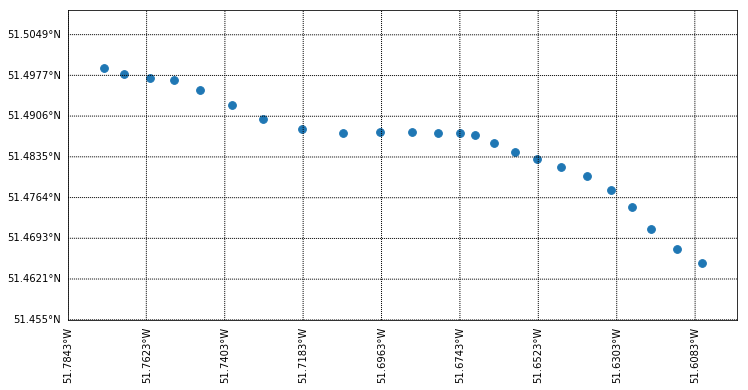

In [39]:
fig, ax = plot.plot_track((tc.ref_lats.values, tc.ref_lons.values), sizes=60)

## Find optimal Ca and Cw

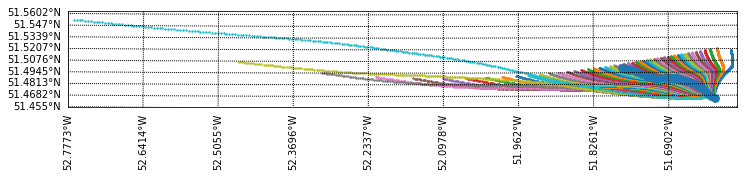

In [40]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 0.1, 0.15
#run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 
                  'perturb_current': True, 'perturb_wind': True,
                  'current_constants': np.array([0.03, -0.01]), 'wind_constants': np.array([-5.08, -3.39])}

N = 50

num_start_times = 1

err_dict = {'Ca': np.zeros((num_start_times, N)), 'Cw': np.zeros((num_start_times, N)), 'err': np.zeros((num_start_times, N))}

for j in range(num_start_times):
    
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #tc = test_case.TestCaseB12(add_timedelta=np.timedelta64(12 * j, 'h'))
    #ref_lats_lons = tc.ref_lats, tc.ref_lons
    #sim.time_frame = tc.time_frame
    #sim.start_location = tc.start_location
    #sim.start_velocity = tc.start_velocity
    #sim.reload_iceberg()

    for i in range(N):

        Ca = 0.001 * i * N
        Cw = 0.001 * N * N - 0.001 * i * N
        #Ca = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = float(np.random.randint(low=35, high=40000, size=1) / 10000)
        #Cw = Ca / 5
        run_sim_kwargs['Ca'] = Ca
        run_sim_kwargs['Cw'] = Cw
        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)
        lats = sim.results.data[f'{i + (j * N)}']['latitude']
        lons = sim.results.data[f'{i + (j * N)}']['longitude']
        lats_lons = lats, lons
        err = calc_mean_error(lats_lons, ref_lats_lons)
        err_dict['Ca'][j][i] = Ca
        err_dict['Cw'][j][i] = Cw
        err_dict['err'][j][i] = err

labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)

err: 0.00786211268939867, Ca: 1.4000000000000001, Cw: 1.0999999999999999


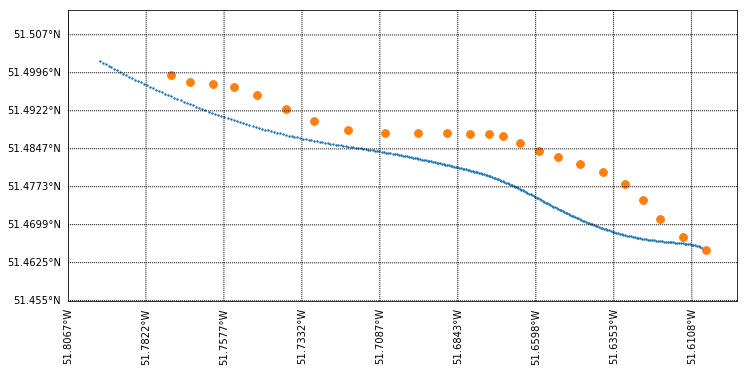

In [42]:
labels = []
for i in range(num_start_times):
    index = np.argmin(err_dict['err'][i][:])
    print('err: {}, Ca: {}, Cw: {}'.format(err_dict['err'][i][index], err_dict['Ca'][i][index], err_dict['Cw'][i][index]))
    labels.append(f'{index + N*i}')
labels += ['reference']
sizes = [2] * num_start_times + [60]
fig, ax = sim.results.plot(labels, sizes=sizes)

## Running Ensemble

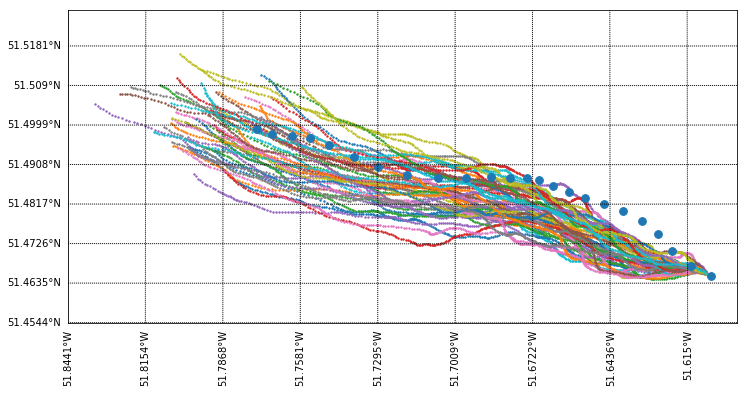

In [58]:
sim_args = tc.time_frame, tc.start_location, tc.start_velocity
sim = simulator.Simulator(*sim_args, **{'ocean_model': 'ECMWF'})
reference_data_dict = {'time': tc.ref_times, 'latitude': tc.ref_lats.values, 'longitude': tc.ref_lons.values}
sim.results.add_from_dict(reference_data_dict, label='reference')
sim.testcase = tc

ref_lats_lons = tc.ref_lats, tc.ref_lons

Ca, Cw = 1.4, 1.1
run_sim_kwargs = {'Ca': Ca, 'Cw': Cw, 'perturb_current': True, 'perturb_wind': True, 'smoothing_constant': 0.2}

N = 50

num_start_times = 1

for j in range(num_start_times):

    for i in range(N):

        sim.run_simulation(label=f'{i + (j * N)}', **run_sim_kwargs)


labels = [str(i) for i in range(N * num_start_times)] + ['reference']
sizes = [2] * N * num_start_times + [60]
markers = ['.'] * (N * num_start_times + 1)
fig, ax = sim.results.plot(labels, sizes=sizes)